# COMP 551 — Assignment 1

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara



Imports

In [34]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import seaborn as sns
from math import factorial
import matplotlib.pyplot as plt
%matplotlib inline

## Functions & Models

### Useful Functions

In [35]:
# Defining minmaxnorm and znorm
def minmaxnorm_series(ser:pd.Series):
  return (ser - ser.min()) / (ser.max() - ser.min())

def znorm_series(ser:pd.Series):
  return (ser - ser.mean()) / ser.std()

def minmaxnorm(df, excl_cols=[]):
  df1 = df.copy()
  for col in df1.columns:
    if col in df1.columns:
      continue
    df1[col] = minmaxnorm_series(df1[col])
  return df1

def znorm(df, excl_cols=[]):
  df1 = df.copy()
  for col in df1.columns:
    if col in excl_cols:
      continue
    df1[col] = znorm_series(df1[col])
  return df1


# Functions to calculate metrics
def root_mean_squared_error(y, yhat):
   return np.sqrt(np.mean((y - yhat)**2))

def mean_absolute_error(y, yhat):
  return np.mean(np.abs(y - yhat))

def r2_score(y, yhat):
  return 1 - np.sum((y - yhat)**2) / np.sum((y - np.mean(y))**2)

def report_metrics(y, yhat):
  print("RMSE:", root_mean_squared_error(y, yhat))
  print("MAE:", mean_absolute_error(y, yhat))
  print("R^2:", r2_score(y, yhat))

def store_lin_metrics(df, rowname, ytrain, yhattrain, ytest, yhattest, test_split, train_split=None, iteration=None, batch_size=None, loss=None, total_epochs=None):
    metrics = {
      "method": rowname,
      "train_RMSE": root_mean_squared_error(ytrain, yhattrain),
      "train_MAE": mean_absolute_error(ytrain, yhattrain),
      "train_R2": r2_score(ytrain, yhattrain),
      "test_RMSE": root_mean_squared_error(ytest, yhattest),
      "test_MAE": mean_absolute_error(ytest, yhattest),
      "test_R2": r2_score(ytest, yhattest),
      "test_split": round(test_split, 1),
      "train_split": 1-test_split if train_split is None else train_split,
      "loss": loss,
      "iteration": iteration,
      "batch_size": batch_size,
      "total_epochs": total_epochs
    }

    return pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)

def accuracy(y, yh):
    yh_class = np.where(yh >= 0.5, 1, 0)
    return np.mean(y == yh_class)

def store_logist_metrics(df, rowname, ytrain, yhattrain, ytest, yhattest, test_split, iteration=None):
  metrics = {
      "method": rowname,
      "train_accuracy": accuracy(ytrain, yhattrain),
      "test_accuracy": accuracy(ytest, yhattest),
      "test_split": round(test_split, 1),
      "train_split": 1-test_split,
      "iteration": iteration
  }
  return pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)


# function to remove outliers
def remove_outliers(df_in, z_threshold=3, excl_cols=[]):
  df = df_in.copy()
  print("========= REMOVING OUTLIERS =========")
  print(f"BEFORE -> N_data = {df.shape[0]}")
  for col in df.columns:
    if col in excl_cols:
      continue
    colmean = df[col].mean()
    colstd = df[col].std()
    uplim = colmean + 3*colstd # above 3 stdev
    lowlim = colmean - 3*colstd # below 3 stdev

    # removing rows with outliers
    df = df[(df[col] < uplim) & (df[col] > lowlim)]

  print(f"AFTER  -> N_data = {df.shape[0]}")
  print("=====================================")

  return df.reset_index(drop=True)


# plotting loss and weights over time
def plot_history(optimizer):
  xs = np.arange(len(optimizer.loss_history))

  fig, ax = plt.subplots(figsize=(10,6))


  # plot loss
  ax.plot(xs, optimizer.loss_history, color='b', label='Loss')
  ax.set_xlabel('Epoch', fontsize=12)
  ax.set_ylabel('Loss', fontsize=12, color='b')
  ax.tick_params(axis='y', labelcolor='b')

  ax1 = ax.twinx()
  ax1.set_ylabel('Weights', fontsize=12, color='r')
  ax1.tick_params(axis='y', labelcolor='r')
  for i in range(len(optimizer.w_history[0])):
      ax1.plot(xs, optimizer.w_history[:, i], label=f'w{i}', alpha=0.7)

  ax1.legend(loc='upper right', fontsize=10, ncols=3)
  ax.legend(loc='upper left', fontsize=10)
  plt.show()

### Model Implementations

#### Linear Regression

In [36]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.N= None # init N
        self.w = None # init w
        self.num_batches = None # batches for gradient descent
        self.loss = None
        self.loss_history = []
        self.w_history = []
        self.grad_history = []
        self.total_epochs = None

    @staticmethod
    def l2_loss(x, y, w):
      return np.mean((y - (x @ w))**2)

    def fit_analytical(self, x, y):
        """
        Fit the model using the analytical solution.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]  # add a dimension for the features
        N = x.shape[0]

        # Add bias term if needed
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])

        # Analytical weight solution using least squares
        self.w = np.linalg.lstsq(x, y)[0]

        # calculate loss for comparisons
        self.loss = LinearRegression.l2_loss(x, y, self.w)
        return self


    def fit_gd_minibatch(self, x, y, optimizer, num_batches=8):
        """
        Fit the model using mini-batch gradient descent.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]

        self.num_batches = num_batches

        # Add bias term if needed
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # Define the gradient function
        def gradient(x, y, w):
            N_batch = x.shape[0]  # batch size
            yh = x @ w
            # grad = (x.T @ (yh - y)) / N_batch
            grad = np.dot(x.T, yh - y)/N_batch
            return grad

        # Run mini-batch GD
        w0 = np.zeros(D)  # initialize the weights to 0
        self.w = optimizer.run_minibatch(gradient,
                                         LinearRegression.l2_loss,
                                         x, y, w0,
                                         self.num_batches
                                         )  # run the optimizer to get the optimal weights

        self.loss = LinearRegression.l2_loss(x, y, self.w)
        self.loss_history = optimizer.loss_history
        self.w_history = optimizer.w_history
        self.grad_history = optimizer.grad_history
        self.total_epochs = optimizer.total_epochs
        return self


    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w  # predict the y values
        return yh


    def __str__(self):
        return f'weights: {self.w}'

#### Logistic Regression

In [37]:
class GradientDescent:
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-6, min_delta_loss=1e-6, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.w_history = []  # to store the weight history for visualization
        self.loss_history = []  # to store the loss history for visualization
        self.grad_history = []
        self.min_delta_loss = min_delta_loss
        self.total_epochs = 0

    def run_fullbatch(self, gradient_fn, loss_fn, x, y, w):
        """
        Run gradient descent using the full batch.
        """
        grad = np.inf
        t = 1
        prev_loss = np.inf

        # loop and check the loss function
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters and np.abs(prev_loss - loss_fn(x, y, w)) > self.min_delta_loss: # Added last check for loss stability
            prev_loss = loss_fn(x, y, w)
            # compute the gradient with present weight
            grad = gradient_fn(x, y, w)               # compute the gradient with present weight
            w = w - self.learning_rate * grad         # weight update step
            loss = loss_fn(x, y, w) # compute the loss with present weight
            if self.record_history:
                self.w_history.append(w.copy())
                self.loss_history.append(loss)
            t += 1
        self.total_epochs = t
        if self.record_history: # Convert lists to numpy arrays
            self.w_history = np.array(self.w_history)
            self.loss_history = np.array(self.loss_history)
        return w


    def run_minibatch(self, gradient_fn, loss_fn, x, y, w, num_batches=8):
        """
        Run gradient descent using mini batches. x and y are the full test sets.
        """
        grad = np.inf
        epoch = 1
        N = x.shape[0]

        # convert data to arrays
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)


        # Gradient descent loop until convergence or max iterations
        prev_loss = np.inf
        while np.linalg.norm(grad) > self.epsilon and epoch < self.max_iters and np.abs(prev_loss - loss_fn(x, y, w)) > self.min_delta_loss:
            prev_loss = loss_fn(x, y, w)

            # Suffle the data at the start of each epoch
            indices = np.random.permutation(N)
            x_shuffled = x[indices]
            y_shuffled = y[indices]

            # Split data into num_batches batches
            x_batches = np.array_split(x_shuffled, num_batches)
            y_batches = np.array_split(y_shuffled, num_batches)

            # loop over mini-batches & update weights
            for x_batch, y_batch in zip(x_batches, y_batches):
                grad = gradient_fn(x_batch, y_batch, w)
                if np.isnan(grad).any():
                    raise ValueError("Gradient contains NaN!")
                w = w - self.learning_rate * grad  # update weights using the batch gradient

            loss = loss_fn(x, y, w)
            if self.record_history:
                self.w_history.append(w.copy())
                self.loss_history.append(loss)
                self.grad_history.append(np.linalg.norm(grad))

            epoch += 1  # counting epochs
        self.total_epochs = epoch
        if self.record_history: # Convert lists to numpy arrays
            self.w_history = np.array(self.w_history)
            self.loss_history = np.array(self.loss_history)
            self.grad_history = np.array(self.grad_history)

        return w

#### Gradient descent

In [38]:
class LogisticRegression:
    def __init__(self, add_bias=True, verbose=False):
        self.add_bias = add_bias
        self.verbose = verbose
        self.w = None  # weights will be initialized during fitting
        self.num_batches = None

    # Define the logistic function
    @staticmethod
    def logistic(z):
        z = np.clip(z, -500, 500) # to avoid overflow
        return 1. / (1 + np.exp(-z))

    # Define the gradient function
    @staticmethod
    def gradient(x, y, w):
        N_batch, D = x.shape
        yh = LogisticRegression.logistic(np.dot(x, w))  # predictions size
        # if yh.ndim == 1:
        #     yh = yh[:, None]
        grad = np.dot(x.T, yh - y)/N_batch
        return grad  # size D

    # loss function
    @staticmethod
    def logistic_loss(x, y, w):
      y_pred = LogisticRegression.logistic(np.dot(x,w))
      return -(1/len(y)) * np.sum(y * np.log(y_pred) + (1-y) * np.log(1-y_pred))

    def fit_gd_fullbatch(self, x, y, optimizer):
        """
        Fit the model using full-batch gradient descent.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]

        # Add bias term if needed
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # Run mini-batch GD
        w0 = np.zeros(D)  # initialize the weights to 0
        self.w = optimizer.run_fullbatch(LogisticRegression.gradient, LogisticRegression.logistic_loss, x, y, w0)  # run the optimizer to get the optimal weights
        return self


    def fit_gd_minibatch(self, x, y, optimizer, num_batches=8):
        """
        Fit the model using mini-batch gradient descent.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]

        self.num_batches = num_batches

        # Add bias term if needed
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # Run mini-batch GD
        w0 = np.zeros(D)  # initialize the weights to 0
        self.w = optimizer.run_minibatch(LogisticRegression.gradient, LogisticRegression.logistic_loss, x, y, w0, self.num_batches)  # run the optimizer to get the optimal weights
        return self


    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = self.logistic(np.dot(x,self.w))  # predict output
        return yh

## Dataset 1: Predict Parkinson’s Motor Scores

### Acquire, preprocess, and analyze the data

#### Load Data

In [39]:
# Fetch dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)
parkdata = parkinsons_telemonitoring.data

# Get features and targets (x and y)
park_feat = parkdata.features
park_targets = parkdata.targets
# park_targets = park_targets["motor_UPDRS"] # <- We want motor_UPDRS (see assignment pdf). Comment this out if we want to keep the total_UPDRS for a better fit!

In [40]:
# Check for empty rows
park_feat.eq('?').any(axis=1).sum() # <- Because the result is `0`, there aren't any malformed data in any rows!

np.int64(0)

#### Remove outliers and normalize the features

In [41]:
### Exclude outliers from each column, except: motor_UPDRS, DFA, and sex ###
parkdf = pd.concat([park_feat, park_targets], axis=1)  # dataframe
excl_cols = ["motor_UPDRS", "DFA", "sex"]  # features to exclude from outlier removal
parkdf_cut = remove_outliers(parkdf,
                             z_threshold=3,
                             excl_cols=excl_cols
                             )

========= REMOVING OUTLIERS =========
BEFORE -> N_data = 5875
AFTER  -> N_data = 4954


In [42]:
### Applying normalization  ###
parkdfnorm = znorm(parkdf_cut, excl_cols=['sex'])  # not normalizing the sex column

#### Clean data based on correlations

In [43]:
### Get correlations for data ###
parkcorr = parkdfnorm.loc[:, parkdfnorm.columns!="motor_UPDRS"].corr() # excluding motor_UPDRS from correlation matrix
np.fill_diagonal(parkcorr.values, np.nan) # set diagonal elements to NaN
# sns.heatmap(parkcorr, cmap='twilight_shifted_r', vmin=-1, vmax=1);

In [44]:
### Cleaning data based on correlations ###
# Part 1: Remove features that are too correlated with each other (threshold = 0.8)
parkcorr_temp = parkcorr.copy()

dropped_features = []
kept_features = []
while True:
  # 1. find highest abs(element), ignoring diagonals
  largest_element = parkcorr_temp.abs().max().max()
  if largest_element < 0.8:
    break

  # 2. get both columns involved
  cols = parkcorr_temp.abs().stack()[parkcorr_temp.abs().stack() == largest_element].index[0]

  # 3. remove the one with greatest avg(corr) across the dataset
  corravg0 = parkcorr_temp[cols[0]].mean()
  corravg1 = parkcorr_temp[cols[1]].mean()

  if corravg0 > corravg1:
    parkcorr_temp = parkcorr_temp.drop(columns=cols[0])
    parkcorr_temp = parkcorr_temp.drop(index=cols[0])
    dropped_features.append(cols[0])
  else:
    parkcorr_temp = parkcorr_temp.drop(columns=cols[1])
    parkcorr_temp = parkcorr_temp.drop(index=cols[1])
    dropped_features.append(cols[1])

for col in park_feat.columns:
  if col not in dropped_features:
    kept_features.append(col)


# Part 2: Remove features that are too uncorrelated with target (threshold = 0.3)
# implement?

print("kept features: ", kept_features)

kept features:  ['age', 'test_time', 'Jitter(Abs)', 'Jitter:RAP', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex']


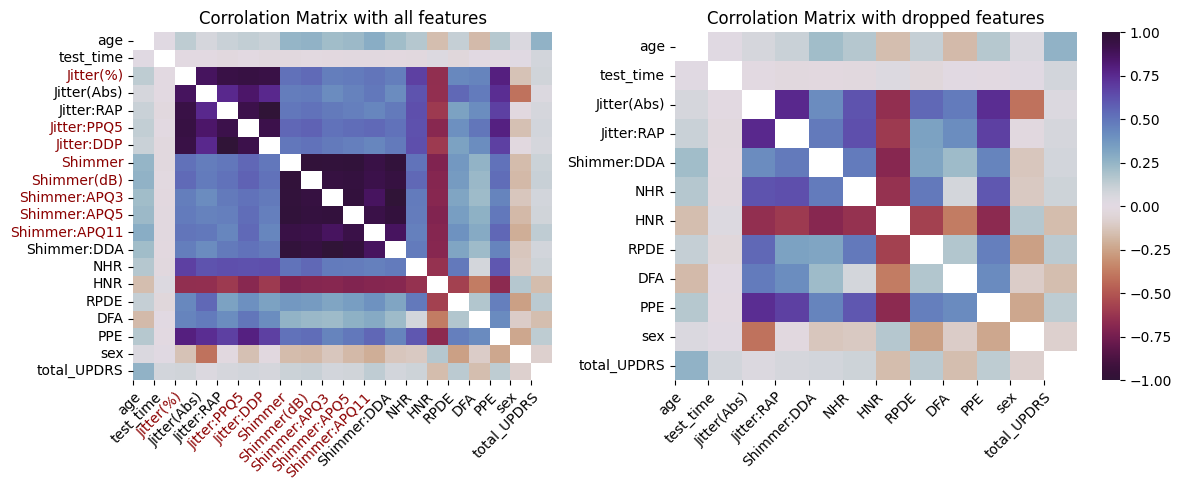

In [45]:
### Report plot: correlation matrices before and after cleaning ###

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False, gridspec_kw={'width_ratios': [1, 1.2]})
sns.heatmap(parkcorr, cmap='twilight_shifted_r', cbar=False, ax=axes[0], vmin=-1, vmax=1)
sns.heatmap(parkcorr_temp, cmap='twilight_shifted_r', ax=axes[1], vmin=-1, vmax=1);

# Setting axis labels
axes[0].set_xticks(range(len(parkcorr.columns)), labels=parkcorr.columns,
              rotation=45, ha="right", rotation_mode="anchor")
axes[1].set_xticks(range(len(parkcorr_temp.columns)), labels=parkcorr_temp.columns,
              rotation=45, ha="right", rotation_mode="anchor")

# Color coding labels (red=dropped features)
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    if label.get_text()=="total_UPDRS" or label.get_text() in kept_features:
        label.set_color("black")
    else:
      label.set_color("darkred")

# Titles
axes[0].set_title("Corrolation Matrix with all features")
axes[1].set_title("Corrolation Matrix with dropped features")

fig.tight_layout()
plt.savefig("./figures/data1_corr.png", bbox_inches='tight', dpi=300)
plt.show()

In [46]:
### Final cleaned dataframe ###
# combining the target and features into one dataframe
parkdf_c = parkdfnorm.drop(columns=dropped_features)
# removing test_time & sex
parkdf_c = parkdf_c.drop(columns=['test_time', 'sex'])
parkdf_c

,age,Jitter(Abs),Jitter:RAP,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS,total_UPDRS
0,0.835102,-0.100980,1.652566,0.071274,-0.403685,-0.296035,-1.160303,-1.466151,-0.586582,0.846457,0.488537
1,0.835102,-0.986336,-0.941829,-0.592042,-0.663687,1.424871,-0.987775,-1.230238,-1.356277,0.876790,0.534501
2,0.835102,-0.580114,-0.237774,-0.980470,0.081466,0.140789,-0.694424,-1.529206,0.155264,0.907124,0.580372
3,0.835102,-0.475954,-0.372798,-0.425217,0.704637,0.574818,-0.424830,-1.040208,1.971808,0.932809,0.619385
4,0.835102,-0.814473,-1.317969,-1.063136,-0.621717,1.096709,-0.590585,-1.281460,-0.089599,0.967301,0.671742
...,...,...,...,...,...,...,...,...,...,...,...
4949,-0.531424,-0.241596,-0.604269,-0.622917,0.483741,-0.069706,1.239712,-1.398047,0.207554,0.147562,0.403931
4950,-0.531424,-0.574906,-1.067209,-0.504894,-0.597009,0.090804,-0.009044,-1.224322,-1.088009,0.086773,0.357875
4951,-0.531424,-0.574906,-0.748938,-0.029319,-0.124621,0.767306,-0.525659,-1.026645,-0.860478,0.026473,0.312190
4952,-0.531424,-0.804057,-0.980408,-1.042220,-0.919598,0.567678,0.449633,-1.251881,-0.853516,-0.033216,0.266968


#### Statistics

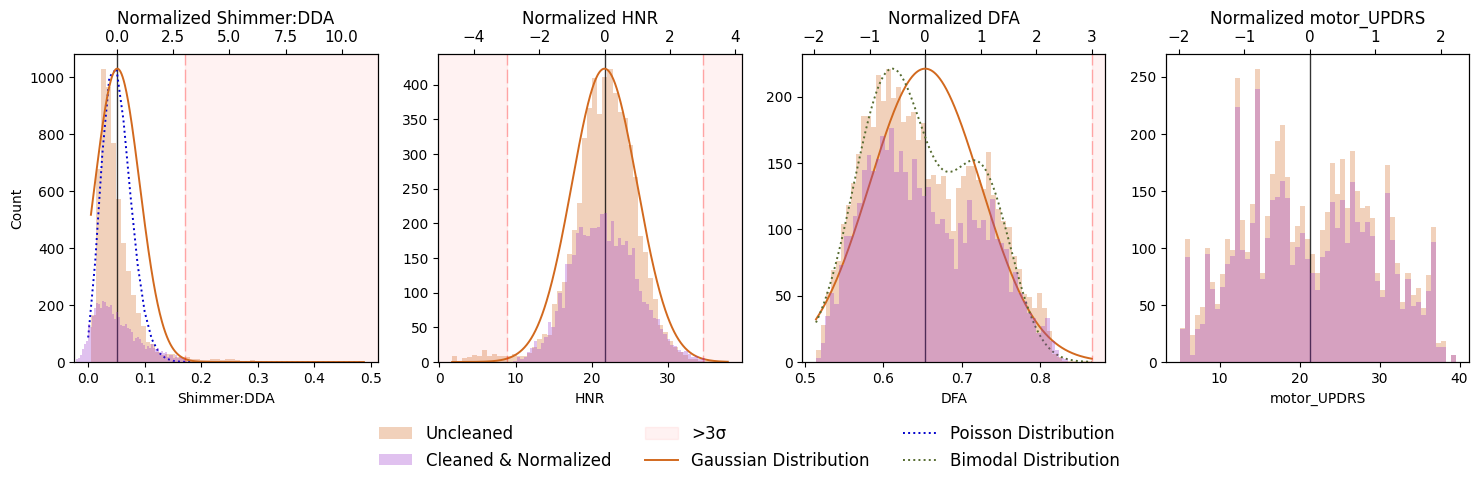

In [47]:
### Plot distributions of selected features & target before and after cleaning ###

fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)
all_handles = []
all_labels = []

# features used in example
parkdf_stats_raw = parkdf[["Shimmer:DDA", "HNR", "DFA", "motor_UPDRS" ]]
parkdf_stats_clean = parkdfnorm[["Shimmer:DDA", "HNR", "DFA", "motor_UPDRS" ]]

# function definitions:
def poisson(x, mu):
  return np.array([mu**k * np.exp(-mu) / factorial(int(k)) for k in x])

def gaussian(x, mu, sigma):
  return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def bimodal(x, mu1, sigma1, mu2, sigma2, ratio=0.5):
    return ratio * gaussian(x, mu1, sigma1) + (1 - ratio) * gaussian(x, mu2, sigma2)

for index, c1 in enumerate(parkdf_stats_raw.columns):
    # set up
    raw = parkdf_stats_raw[c1]
    clean = parkdf_stats_clean[c1]
    mean = raw.mean()
    std = raw.std()
    bin = 55

    # seperate the two sides
    inside_mask = (raw >= mean - 3*std) & (raw <= mean + 3*std)
    outside_mask = ~inside_mask

    # raw data
    sns.histplot(raw, ax=axes[index], bins=bin, color='chocolate', alpha=.3, 
                 label='Uncleaned', kde=False, linestyle="-", element="step", 
                 edgecolor=None, line_kws={'alpha': .35, 'linewidth' : 0.8}
                 )
    counts, bin_edges = np.histogram(raw, bins=bin) # for the gaussian plot

    # cleaned data
    ax_top = axes[index].twiny()
    sns.histplot(clean, kde=False, label='Cleaned & Normalized', bins=bin, ax=ax_top,  
                 color='darkorchid', alpha=.3, edgecolor=None, element="step", 
                 line_kws={'alpha': .35, 'linewidth' :0.8}
                 )
    axes[index].axvline(x=mean, color='b', linewidth=0.99, alpha=.8, label=f"Mean: {mean:.2f}", c="black")
    ax_top.set_xlabel(f"Normalized {c1}", fontsize=12, color='black')
    ax_top.tick_params(labelsize=11, color='black', labelcolor='black')

    # fixing the normalized axis + adding distributions
    x = np.linspace(raw.min(), raw.max(), 500)
    if index == 0:

      # normalized axis
      scale_factor = 80
      raw_scaled = np.round(raw * scale_factor)
      mean_scaled = raw_scaled.mean()
      std_scaled = raw_scaled.std()
      ax_top.set_xlim((axes[index].get_xlim()[0] * scale_factor - mean_scaled) / std_scaled, 
                      (axes[index].get_xlim()[1] * scale_factor - mean_scaled) / std_scaled
                      )

      # poisson dist
      x_scaled = np.arange(raw_scaled.min(), raw_scaled.max() + 1)
      y_poiss = poisson(x_scaled, mean_scaled)
      y = y_poiss * max(counts) / max(y_poiss)
      x_original = x_scaled / scale_factor
      axes[index].plot(x_original, y, color='mediumblue', linestyle=':', linewidth=1.4, label='Poisson Distribution')

    if index in {0, 1, 2}:
      # normalized axis
      ax_top.set_xlim((axes[index].get_xlim()[0] - mean) / std,(axes[index].get_xlim()[1] - mean) / std)

      # gaussian dist
      x = np.linspace(raw.min(), raw.max(), 500)
      y_gauss = gaussian(x, mean, std)
      y = y_gauss * max(counts) / max(y_gauss)
      axes[index].plot(x, y, color='chocolate', linestyle='-', linewidth=1.4, label='Gaussian Distribution')

    if index == 2:
      #binomial dist
      x = np.linspace(raw.min(), raw.max(), 500)
      y_gauss = bimodal(x, 0.61,  0.048, 0.725, 0.038, ratio=.67)
      y = y_gauss * max(counts) / max(y_gauss)
      axes[index].plot(x, y, color='darkolivegreen', linestyle=':', linewidth=1.4, label='Bimodal Distribution')

    # >3σ cuts
    axes[index].set_ylim(axes[index].get_ylim())
    axes[index].set_xlim(axes[index].get_xlim())
    axes[index].axvline(x=mean+3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
    axes[index].axvline(x=mean-3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
    axes[index].fill_betweenx(axes[index].get_ylim(),axes[index].get_xlim()[0], mean - 3*std, color='r', alpha=.05, label='>3σ')
    axes[index].fill_betweenx(axes[index].get_ylim(), mean + 3*std ,axes[index].get_xlim()[1], color='r', alpha=.05)

   # labels & legend
    handles, labels = axes[index].get_legend_handles_labels()
    for h, l in zip(handles, labels):
        if h not in all_handles:
            all_handles.append(h)
            all_labels.append(l)
    handles_top, labels_top = ax_top.get_legend_handles_labels()
    for h, l in zip(handles_top, labels_top):
        if h not in all_handles:
            all_handles.append(h)
            all_labels.append(l)
    if index != 0:
        axes[index].set_ylabel("")  # hide y-axis labels for all but the first subplot


# getting the right order
handle_dict = dict(zip(all_labels, all_handles))
legend_order = ["Uncleaned", "Cleaned & Normalized", ">3σ", "Gaussian Distribution", "Poisson Distribution", "Bimodal Distribution"]
fig.legend([handle_dict[l] for l in legend_order if l in handle_dict],
           [l for l in legend_order if l in handle_dict],
           loc='upper center', bbox_to_anchor=(0.5, -0.01),
           ncol=3, fontsize=12, frameon=False)

plt.savefig("./figures/data1_dist.png", bbox_inches='tight', dpi=300)
plt.show()

### Run experiments

#### 1. 80/20 train/test split

In [48]:
### Splitting the data into training and testing sets ###
test_split = 0.2  # for 80/20 train/test split
park_test = parkdf_c.sample(frac=test_split).reset_index(drop=True)  # random test set
park_train = parkdf_c.drop(park_test.index).reset_index(drop=True)  # training set

# Define target and features for both sets
y_train = park_train["motor_UPDRS"]
x_train = park_train.drop(columns=["motor_UPDRS"])
y_test = park_test["motor_UPDRS"]
x_test = park_test.drop(columns=["motor_UPDRS"])

In [53]:
### Run Analytical Linear Regression ###
# Train linear model on the full training set
lin_model_analytical = LinearRegression()
yh_analytical = lin_model_analytical.fit_analytical(x_train,y_train).predict(x_train)

# Print optimal weights
print(f'Features: {x_train.columns}')
print(lin_model_analytical)

# Test linear model
yh_test = lin_model_analytical.predict(x_test)

# Store metrics
lin_analytical_df = pd.DataFrame()
lin_analytical_df = store_lin_metrics(lin_analytical_df, 'analytical', y_train, yh_analytical, 
                                  y_test, yh_test, test_split, loss=lin_model_analytical.loss
                                  )
lin_analytical_df

Features: Index(['age', 'Jitter(Abs)', 'Jitter:RAP', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE',
       'DFA', 'PPE', 'total_UPDRS'],
      dtype='object')
weights: [-0.03327735 -0.19552559  0.0790188  -0.01234177  0.03897733  0.00870935
  0.01601193  0.0318488   0.05990754  0.94862968 -0.02728329]


,method,train_RMSE,train_MAE,train_R2,test_RMSE,test_MAE,test_R2,test_split,train_split,loss,iteration,batch_size,total_epochs
0,analytical,0.318515,0.242964,0.900011,0.312007,0.238142,0.899741,0.2,0.8,0.101452,None,None,None


In [54]:
### Run MiniBatch Gradient Descent Linear Regression ###
# Model
lin_model_gd = LinearRegression()  # new model for GD weights
optimizer = GradientDescent(learning_rate=.001, epsilon=1e-3, max_iters=1200, record_history=True)

# Train linear model on the full training set
num_batches = 8
yh_gd = lin_model_gd.fit_gd_minibatch(x_train, y_train, optimizer, num_batches=num_batches).predict(x_train)

# Print optimal weights
print(f'Features: {x_train.columns}')
print(lin_model_gd)

# Test linear model
yh_test_gd = lin_model_gd.predict(x_test)

# Store metrics
lin_gd_df = pd.DataFrame()
lin_gd_df = store_lin_metrics(lin_gd_df, 'minibatch GD', y_train, yh_gd, 
                                  y_test, yh_test_gd, test_split, loss=lin_model_gd.loss
                                  )
lin_gd_df

Features: Index(['age', 'Jitter(Abs)', 'Jitter:RAP', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE',
       'DFA', 'PPE', 'total_UPDRS'],
      dtype='object')
weights: [-0.03125979 -0.16423747  0.06579758 -0.01870375  0.02709464 -0.01151414
  0.00470358  0.01819751  0.05250039  0.94539067 -0.02529989]


,method,train_RMSE,train_MAE,train_R2,test_RMSE,test_MAE,test_R2,test_split,train_split,loss,iteration,batch_size,total_epochs
0,minibatch GD,0.319092,0.243337,0.899649,0.309815,0.23536,0.901146,0.2,0.8,0.101819,None,None,None


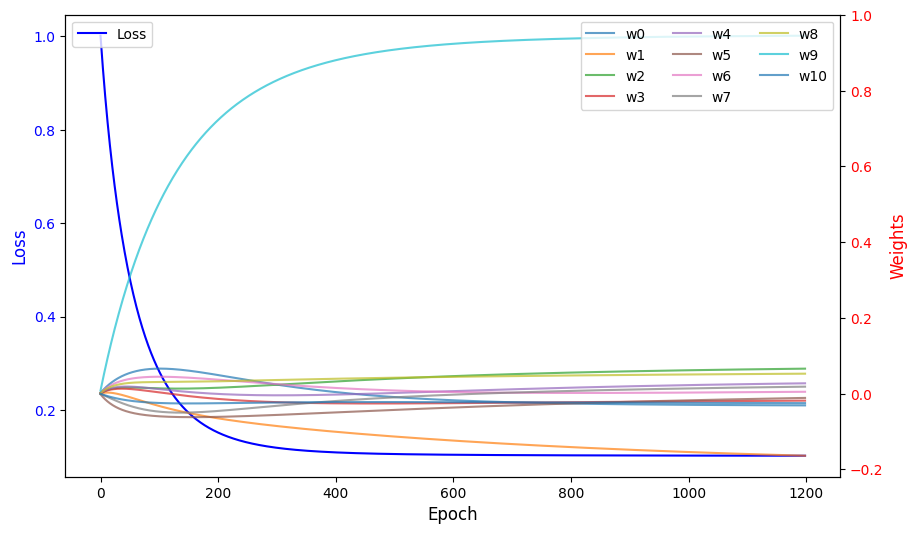

In [ ]:
# Plot history of loss and weights
plot_history(lin_model_gd)

#### 2. Sample growing subsets of the training data

In [ ]:
### Training on 20%-80% of the full training set ###
train_split_range = np.arange(0.2, 0.81, 0.1)
lin_method_splits_df = pd.DataFrame()
iterations = 16  # number of iterations for each train split (to average out randomness)

for train_split in train_split_range:
  for i in range(iterations):
    # print(f"Train split: {train_split:.1} == iteration {i+1}/{iterations}")
    park_train_temp = park_train.sample(frac=train_split).reset_index(drop=True)

    y_train = park_train_temp["motor_UPDRS"]
    x_train = park_train_temp.drop(columns=["motor_UPDRS"])

    # ANALYTICAL MODEL
    lin_model_analytical = LinearRegression()
    yh_analytical_train = lin_model_analytical.fit_analytical(x_train, y_train).predict(x_train)
    yh_analytical_test = lin_model_analytical.predict(x_test)
    lin_method_splits_df = store_lin_metrics(lin_method_splits_df, 'analytical', y_train, yh_analytical_train, y_test, yh_analytical_test, 0.2, round(train_split*0.8,1), i, loss=lin_model_analytical.loss)

    # GRADIENT MODEL MINI-BATCH
    optimizer = GradientDescent(learning_rate=.001, min_delta_loss=5e-6, max_iters=10000, epsilon=1e-3, record_history=False)
    lin_model_gd = LinearRegression()  # create new model obj to get new weights
    yh_gd_train = lin_model_gd.fit_gd_minibatch(x_train, y_train, optimizer).predict(x_train)
    yh_gd_test = lin_model_gd.predict(x_test)
    lin_method_splits_df = store_lin_metrics(lin_method_splits_df, 'mini-batch', y_train, yh_gd_train, y_test, yh_gd_test, 0.2, round(train_split*0.8,1), i, loss=lin_model_gd.loss, batch_size=lin_model_gd.num_batches, total_epochs=lin_model_gd.total_epochs)


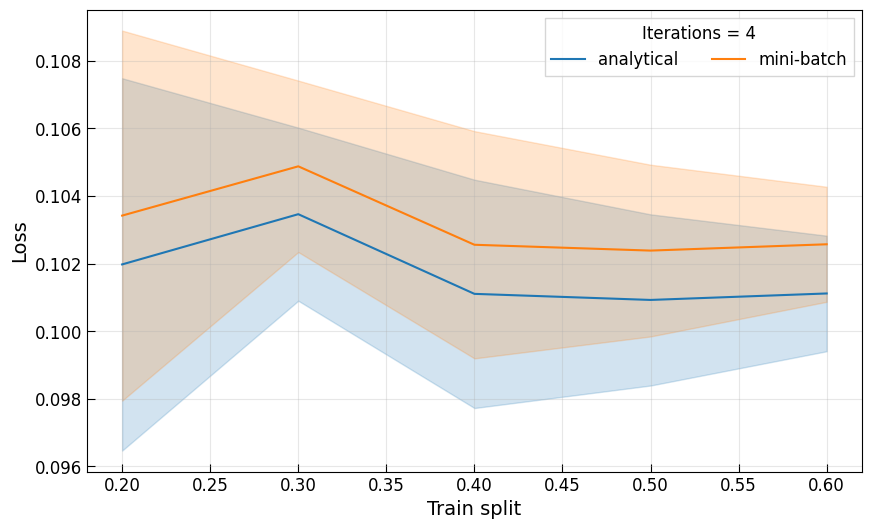

In [444]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(ax=ax,
             data=lin_method_splits_df,
             x="train_split",
             y="loss",
             hue='method',
             errorbar='sd' # stdev to show the variability of loss between iterations
             )

ax.grid(alpha=.3)
ax.set_xlabel("Train split", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.tick_params(labelsize=12, direction='in', length=6)
ax.legend(loc='best', fontsize=12, ncols=2, fancybox=False, title=f'Iterations = {iterations}', title_fontsize=12)
plt.show()

plt.show()

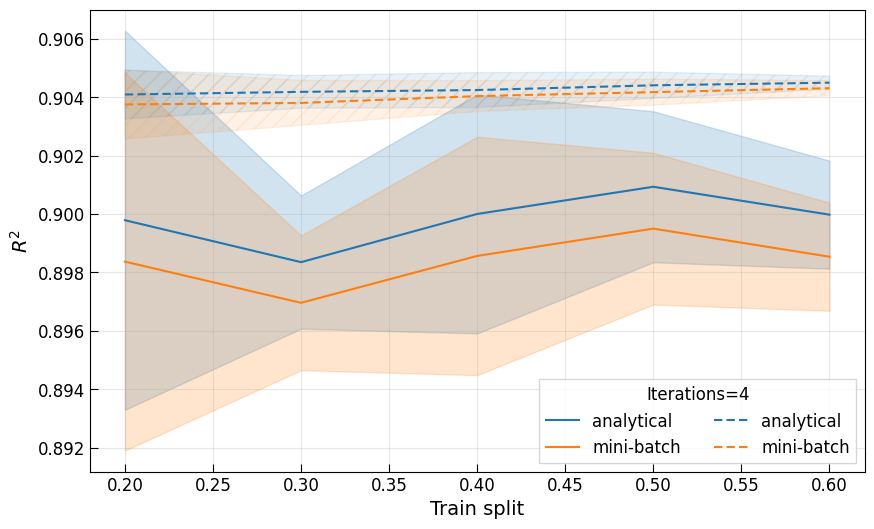

In [443]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(ax=ax,
             data=lin_method_splits_df,
             x="train_split",
             y="train_R2",
             hue='method',
             errorbar='sd' # stdev to show the variability of loss between iterations
             )

sns.lineplot(ax=ax,
             data=lin_method_splits_df,
             x="train_split",
             y="test_R2",
             hue='method',
             style='method',
             dashes={'analytical': (4,2), 'mini-batch': (4,2)},
             errorbar='sd'# stdev to show the variability of loss between iterations
             )

# Apply hatches to the error bands
for collection in ax.collections[2:]:
  collection.set_hatch('//')
  collection.set_alpha(0.1)   # keep it transparent so hatch is visible

ax.grid(alpha=.3)
ax.set_xlabel("Train split", fontsize=14)
ax.set_ylabel("$R^2$", fontsize=14)
ax.tick_params(labelsize=12, direction='in', length=6)
ax.legend(loc='best', fontsize=12, ncols=2, fancybox=False, title=f'Iterations={iterations}', title_fontsize=12)
plt.show()

plt.show()

In [ ]:
# ### Averaging & computing LOSS statistics ###

# # ANALYTICAL MODEL
# lin_analytical_stats = (
#     lin_method_splits_df[lin_method_splits_df["method"] == "analytical"]
#     .groupby("train_split")
#     .agg(median_loss=("loss", "median"), mean_loss=("loss", "mean"), std_loss=("loss", "std"))
#     .reset_index())
# lin_analytical_stats["upper_loss"] = lin_analytical_stats["mean_loss"] + lin_analytical_stats["std_loss"]
# lin_analytical_stats["lower_loss"] = lin_analytical_stats["mean_loss"] - lin_analytical_stats["std_loss"]


# # GRADIENT MODEL MINI-BATCH
# lin_mini_stats = (
#     lin_method_splits_df[lin_method_splits_df["method"] == "mini-batch"]
#     .groupby("train_split")
#     .agg(median_loss=("loss", "median"), mean_loss=("loss", "mean"), std_loss=("loss", "std"))
#     .reset_index()
# )
# lin_mini_stats["upper_loss"] = lin_mini_stats["mean_loss"] + lin_mini_stats["std_loss"]
# lin_mini_stats["lower_loss"] = lin_mini_stats["mean_loss"] - lin_mini_stats["std_loss"]



# ### Plotting Results ###
# # plot R^2 vs test_split for both analytical and mini-batch
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(lin_analytical_stats["train_split"], lin_analytical_stats["median_loss"], label="Analytical Loss", c='b')
# ax.fill_between(lin_analytical_stats["train_split"], lin_analytical_stats["lower_loss"], lin_analytical_stats["upper_loss"], color='b', alpha=.2)

# ax.plot(lin_mini_stats["train_split"], lin_mini_stats["median_loss"], label="Mini-Batch Loss", c='r')
# ax.fill_between(lin_mini_stats["train_split"], lin_mini_stats["lower_loss"], lin_mini_stats["upper_loss"], color='r', alpha=.2)

# # # secondary x-axis for test splits
# # testax = ax.twiny()
# # testax.set_xlim(ax.get_xlim())  # align with train split axis
# # testax.set_xticks(lin_analytical_stats["train_split"])
# # # testax.set_xticklabels(lin_analytical_stats["test_split"])
# # testax.set_xlabel("Test split", fontsize=14)
# # testax.tick_params(labelsize=12, direction='in', length=6)

# ax.grid(alpha=.3)
# ax.set_xlabel("Train split", fontsize=14)
# ax.set_ylabel("$R^2$", fontsize=14)
# ax.tick_params(labelsize=12, direction='in', right=True, length=6)
# ax.legend(loc=(0.43, 0.3), fontsize=12, ncols=2, shadow=True, fancybox=False, title=f'Iterations={iterations}', title_fontsize=12)
# plt.show()

# # lin_r2_mini_stats.head()

In [ ]:
# ### Averaging & computing statistics ###

# # ANALYTICAL MODEL
# lin_r2_analytical_stats = (
#     lin_method_splits_df[lin_method_splits_df["method"] == "analytical"]
#     .groupby("test_split")
#     .agg(median_test=("test_R2", "median"), mean_test=("test_R2", "mean"), std_test=("test_R2", "std"),
#          median_train=("train_R2", "median"), mean_train=("train_R2", "mean"), std_train=("train_R2", "std"))
#     .reset_index())
# lin_r2_analytical_stats["upper_test"] = lin_r2_analytical_stats["mean_test"] + lin_r2_analytical_stats["std_test"]
# lin_r2_analytical_stats["lower_test"] = lin_r2_analytical_stats["mean_test"] - lin_r2_analytical_stats["std_test"]
# lin_r2_analytical_stats["upper_train"] = lin_r2_analytical_stats["mean_train"] + lin_r2_analytical_stats["std_train"]
# lin_r2_analytical_stats["lower_train"] = lin_r2_analytical_stats["mean_train"] - lin_r2_analytical_stats["std_train"]
# lin_r2_analytical_stats["train_split"] = 1-lin_r2_analytical_stats["test_split"]

# # GRADIENT MODEL MINI-BATCH
# lin_r2_mini_stats = (
#     lin_method_splits_df[lin_method_splits_df["method"] == "mini-batch"]
#     .groupby("test_split")
#     .agg(median_test=("test_R2", "median"), mean_test=("test_R2", "mean"), std_test=("test_R2", "std"),
#          median_train=("train_R2", "median"), mean_train=("train_R2", "mean"), std_train=("train_R2", "std"))
#     .reset_index()
# )
# lin_r2_mini_stats["upper_test"] = lin_r2_mini_stats["mean_test"] + lin_r2_mini_stats["std_test"]
# lin_r2_mini_stats["lower_test"] = lin_r2_mini_stats["mean_test"] - lin_r2_mini_stats["std_test"]
# lin_r2_mini_stats["upper_train"] = lin_r2_mini_stats["mean_train"] + lin_r2_mini_stats["std_train"]
# lin_r2_mini_stats["lower_train"] = lin_r2_mini_stats["mean_train"] - lin_r2_mini_stats["std_train"]
# lin_r2_mini_stats["train_split"] = 1-lin_r2_mini_stats["test_split"]



# ### Plotting Results ###
# # plot R^2 vs test_split for both analytical and mini-batch
# fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(lin_r2_analytical_stats["train_split"], lin_r2_analytical_stats["median_test"], label="Analytical test", c='b')
# ax.fill_between(lin_r2_analytical_stats["train_split"], lin_r2_analytical_stats["lower_test"], lin_r2_analytical_stats["upper_test"], color='b', alpha=.2)
# ax.plot(lin_r2_analytical_stats["train_split"], lin_r2_analytical_stats["median_train"], label="Analytical train", c='b', ls='--', alpha=.3)
# ax.fill_between(lin_r2_analytical_stats["train_split"], lin_r2_analytical_stats["lower_train"], lin_r2_analytical_stats["upper_train"], color='b', alpha=.2, hatch='//')

# ax.plot(lin_r2_mini_stats["train_split"], lin_r2_mini_stats["median_test"], label="Mini-batch test", c='r')
# ax.fill_between(lin_r2_mini_stats["train_split"], lin_r2_mini_stats["lower_test"], lin_r2_mini_stats["upper_test"], color='r', alpha=.2)
# ax.plot(lin_r2_mini_stats["train_split"], lin_r2_mini_stats["median_train"], label="Mini-batch train", c='r', ls='--', alpha=.4)
# ax.fill_between(lin_r2_mini_stats["train_split"], lin_r2_mini_stats["lower_train"], lin_r2_mini_stats["upper_train"], color='r', alpha=.2, hatch='//')

# # secondary x-axis for test splits
# testax = ax.twiny()
# testax.set_xlim(ax.get_xlim())  # align with train split axis
# testax.set_xticks(lin_r2_analytical_stats["train_split"])
# testax.set_xticklabels(lin_r2_analytical_stats["test_split"])
# testax.set_xlabel("Test split", fontsize=14)
# testax.tick_params(labelsize=12, direction='in', length=6)

# ax.grid(alpha=.3)
# ax.set_xlabel("Train split", fontsize=14)
# ax.set_ylabel("$R^2$", fontsize=14)
# ax.tick_params(labelsize=12, direction='in', right=True, length=6)
# ax.legend(loc=(0.43, 0.3), fontsize=12, ncols=2, shadow=True, fancybox=False, title=f'Iterations={iterations}', title_fontsize=12)
# plt.show()

# lin_r2_mini_stats.head()

In [ ]:
### VARYING BATCH SIZE ###
batch_sizes = [8, 16, 32, 64, 128]
iterations = 16

# 80/20 train/test split
x_train = park_train.drop(columns=["motor_UPDRS"])
y_train = park_train["motor_UPDRS"]
x_test = park_test.drop(columns=["motor_UPDRS"])
y_test = park_test["motor_UPDRS"]

convergence_times = []
lin_batch_df = pd.DataFrame()
for batch_size in batch_sizes:
  for i in range(iterations):
    # print(f"Batch size: {batch_size} == iteration {i+1}/{iterations}")
    optimizer = GradientDescent(learning_rate=.01, epsilon=1e-3, max_iters=10000, record_history=True)
    lin_model_gd = LinearRegression()  # create new model obj to get new weights
    yh_gd = lin_model_gd.fit_gd_minibatch(x_train, y_train, optimizer, batch_size).predict(x_train)
    yh_test_gd = lin_model_gd.predict(x_test)
    lin_batch_df = store_lin_metrics(lin_batch_df, 'mini-batch', y_train, yh_gd, y_test, yh_test_gd, 0.2, 0.8, i, batch_size, lin_model_gd.loss, lin_model_gd.total_epochs)
    convergence_times.append(lin_model_gd.total_epochs)

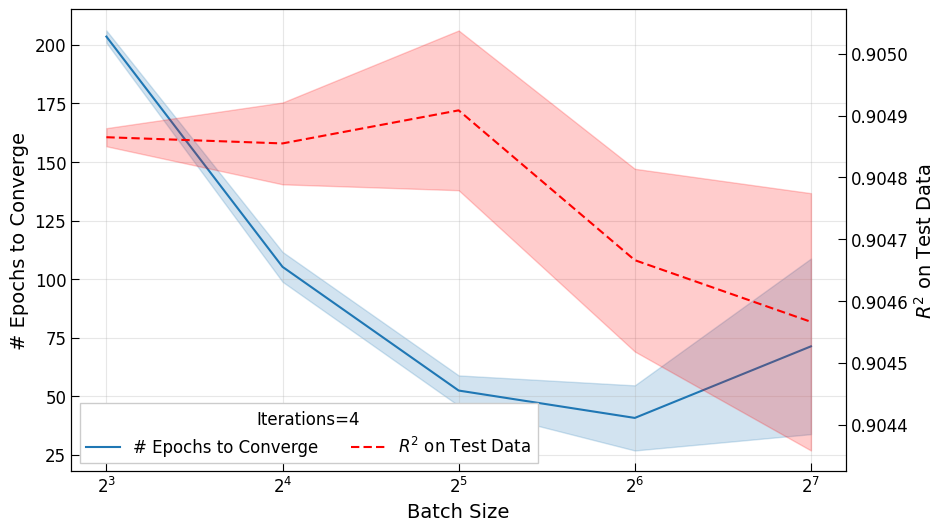

In [442]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(ax=ax,
             data=lin_batch_df,
             x="batch_size",
             y="total_epochs",
             errorbar='sd',
             label=['total_epochs'],
             )

ax.grid(alpha=.3)
# ax.plot(batch_sizes, convergence_times)
# ax.set_xlabel('Batch Size')
# ax.set_ylabel('# Epochs until Convergence')

ax1 = ax.twinx()
sns.lineplot(ax=ax1,
             data=lin_batch_df,
             x="batch_size",
             y="test_R2",
             style='method',
             dashes={'mini-batch': (4,2)},
             errorbar='sd',
             color='r'
             )


# ax1.plot(batch_sizes, lin_batch_df['test_R2'], color='r', label='Test R^2')
# ax1.set_ylabel('Test $R^2$', color='r')
# ax1.tick_params(axis='y', labelcolor='r')

handles, _ = ax.get_legend_handles_labels()
handles1, _ = ax1.get_legend_handles_labels()
ax.legend().remove()
ax1.legend(handles + handles1, ['# Epochs to Converge', '$R^2$ on Test Data'], framealpha=1, loc='best', fontsize=12, ncols=2, fancybox=False, title=f'Iterations={iterations}', title_fontsize=12)

ax.tick_params(labelsize=12, direction='in', length=6)
ax1.tick_params(labelsize=12, direction='in', length=6)

ax.set_ylabel("# Epochs to Converge", fontsize=14)
ax1.set_ylabel("$R^2$ on Test Data", fontsize=14)
ax.set_xlabel('Batch Size', fontsize=14)

ax.set_xscale('log', base=2)

plt.show()

# Dataset 2: Breast Cancer Prediction

#### Load Data

In [ ]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
breastdata = breast_cancer_wisconsin_diagnostic.data

# Get features and targets (x and y)
breast_feat = breastdata.features
breast_targets = breastdata.targets

In [ ]:
# Look at features
breast_feat.describe()

In [ ]:
### NOTE: DECIDED NOT TO DO `OHE` FOR DIAGNOSIS TO AVOID DOING SOFTMAX... WE ARE WORKING WITH BINARY TARGET ANYWAY
# breast_targets_OHE = pd.get_dummies(breast_targets, dtype=float)
# target_cols = breast_targets_OHE.columns.to_list()
# breast_targets_OHE.value_counts()
breast_targets_mapped = breast_targets.copy()
breast_targets_mapped['Diagnosis'] = breast_targets_mapped['Diagnosis'].map({'B': 0, 'M': 1})
breast_targets_mapped.value_counts()

#### Clean Data

In [ ]:
# Remove outliers
breastdf = pd.concat([breast_targets_mapped, breast_feat], axis=1)
breastdf_cut = remove_outliers(breastdf,
                              z_threshold=3,
                              excl_cols=['Diagnosis']
                              )

In [ ]:
breastdfnorm = znorm(breastdf_cut, excl_cols='Diagnosis')
# breastdfnorm = breastdf_cut.copy()

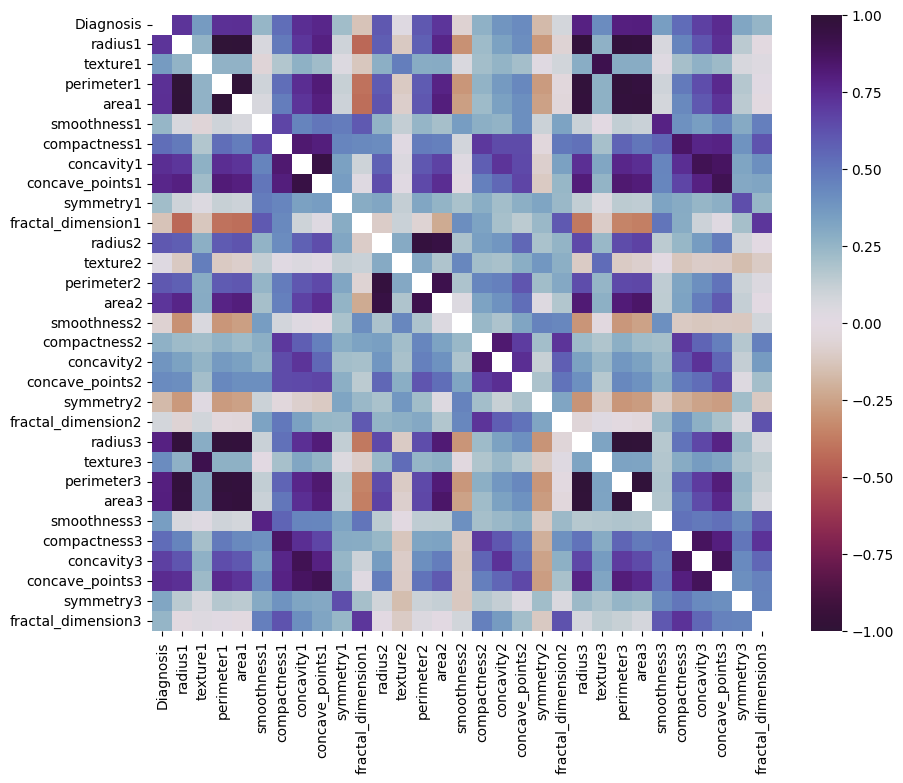

In [448]:
# breast_feat.corr()parkcorr = parkdfnorm.loc[:, parkdfnorm.columns!="motor_UPDRS"].corr() # excluding motor_UPDRS from correlation matrix

# breast_corr = breastdfnorm.loc[:, ~breastdfnorm.columns.str.contains('Diagnosis')].corr()
fig, ax = plt.subplots(figsize=(10,8))
breast_corr = breastdfnorm.corr()
np.fill_diagonal(breast_corr.values, np.nan)
sns.heatmap(breast_corr, cmap='twilight_shifted_r', vmin=-1, vmax=1, ax=ax)
plt.show()

kept features:  ['Diagnosis', 'radius1', 'texture1', 'smoothness1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'smoothness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'smoothness3', 'compactness3', 'concave_points3', 'symmetry3', 'fractal_dimension3']


<Axes: >

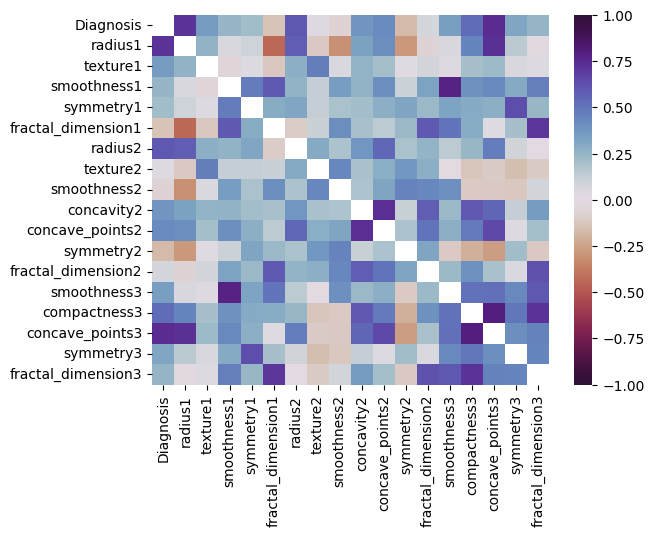

In [438]:
### Cleaning data based on correlations ###

# Remove features that are too correlated with each other
# Remove features that are too uncorrelated with target

breast_corr_temp = breast_corr.copy()

dropped_features = []
kept_features = []
while True:
  # 1. find highest abs(element), ignoring diagonals
  largest_element = breast_corr_temp.abs().max().max()
  if largest_element < 0.8: # MAX CORRELATION (to change if desired)
    break

  # 2. get both columns involved
  cols = breast_corr_temp.abs().stack()[breast_corr_temp.abs().stack() == largest_element].index[0]
  # print(cols)

  # 3. remove the one with greatest avg(corr) across the dataset
  corravg0 = breast_corr_temp[cols[0]].mean()
  corravg1 = breast_corr_temp[cols[1]].mean()
  # print(corravg1)
  # print(corravg2)

  if corravg0 > corravg1:
    # print("dropping ", cols[0])
    breast_corr_temp = breast_corr_temp.drop(columns=cols[0])
    breast_corr_temp = breast_corr_temp.drop(index=cols[0])
    dropped_features.append(cols[0])
  else:
    # print("dropping ", cols[1])
    breast_corr_temp = breast_corr_temp.drop(columns=cols[1])
    breast_corr_temp = breast_corr_temp.drop(index=cols[1])
    dropped_features.append(cols[1])

for col in breastdfnorm.columns:
  if col not in dropped_features:
    kept_features.append(col)

print("kept features: ", kept_features)

sns.heatmap(breast_corr_temp, cmap='twilight_shifted_r', vmin=-1, vmax=1)

array([[<Axes: title={'center': 'Diagnosis'}>,
        <Axes: title={'center': 'radius1'}>,
        <Axes: title={'center': 'texture1'}>,
        <Axes: title={'center': 'smoothness1'}>],
       [<Axes: title={'center': 'symmetry1'}>,
        <Axes: title={'center': 'fractal_dimension1'}>,
        <Axes: title={'center': 'radius2'}>,
        <Axes: title={'center': 'texture2'}>],
       [<Axes: title={'center': 'smoothness2'}>,
        <Axes: title={'center': 'concavity2'}>,
        <Axes: title={'center': 'concave_points2'}>,
        <Axes: title={'center': 'symmetry2'}>],
       [<Axes: title={'center': 'fractal_dimension2'}>,
        <Axes: title={'center': 'smoothness3'}>,
        <Axes: title={'center': 'compactness3'}>,
        <Axes: title={'center': 'concave_points3'}>],
       [<Axes: title={'center': 'symmetry3'}>,
        <Axes: title={'center': 'fractal_dimension3'}>, <Axes: >,
        <Axes: >]], dtype=object)

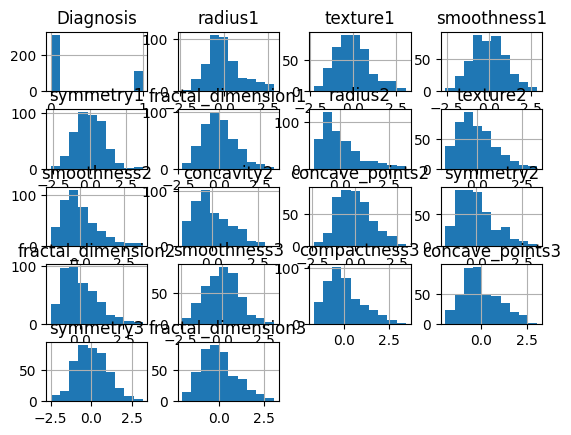

In [441]:
# FINAL CLEANED LOGISTIC REGRESSION DATA
breastdf_c = breastdfnorm[kept_features]
breastdf_c.hist()


#### Statistics

array([[<Axes: title={'center': 'Diagnosis'}>,
        <Axes: title={'center': 'radius1'}>,
        <Axes: title={'center': 'texture1'}>,
        <Axes: title={'center': 'smoothness1'}>],
       [<Axes: title={'center': 'symmetry1'}>,
        <Axes: title={'center': 'fractal_dimension1'}>,
        <Axes: title={'center': 'radius2'}>,
        <Axes: title={'center': 'texture2'}>],
       [<Axes: title={'center': 'smoothness2'}>,
        <Axes: title={'center': 'concavity2'}>,
        <Axes: title={'center': 'concave_points2'}>,
        <Axes: title={'center': 'symmetry2'}>],
       [<Axes: title={'center': 'fractal_dimension2'}>,
        <Axes: title={'center': 'smoothness3'}>,
        <Axes: title={'center': 'compactness3'}>,
        <Axes: title={'center': 'concave_points3'}>],
       [<Axes: title={'center': 'symmetry3'}>,
        <Axes: title={'center': 'fractal_dimension3'}>, <Axes: >,
        <Axes: >]], dtype=object)

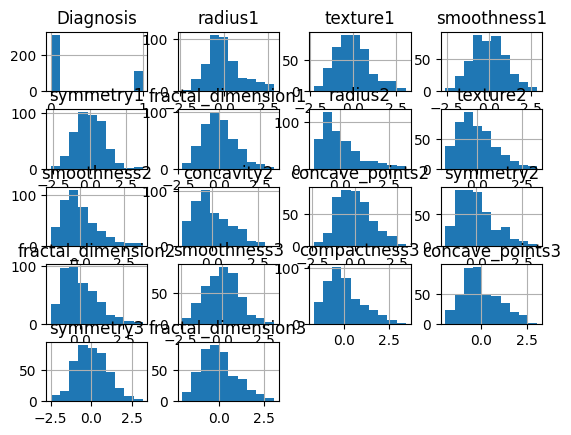

In [ ]:
# showing off the statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
all_handles = []
all_labels = []

# features used in example
parkdf_stats_raw = parkdf[["texture1", "radius2", "Diagnosis" ]]
breastdf_clean = breastdf_c[["texture1", "HNR", "DFA", "Diagnosis"]]

# function definitions:
def poisson(x, mu):
  return np.array([mu**k * np.exp(-mu) / factorial(int(k)) for k in x])

def gaussian(x, mu, sigma):
  return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def bimodal(x, mu1, sigma1, mu2, sigma2, ratio=0.5):
    return ratio * gaussian(x, mu1, sigma1) + (1 - ratio) * gaussian(x, mu2, sigma2)

for index, c1 in enumerate(parkdf_stats_raw.columns):
    # set up
    raw = parkdf_stats_raw[c1]
    clean = parkdf_stats_clean[c1]
    mean = raw.mean()
    std = raw.std()
    bin = 55

    # seperate the two sides
    inside_mask = (raw >= mean - 3*std) & (raw <= mean + 3*std)
    outside_mask = ~inside_mask

    # raw data
    sns.histplot(raw, ax=axes[index], bins=bin, color='chocolate', alpha=.3, 
                 label='Uncleaned', kde=False, linestyle="-", element="step", 
                 edgecolor=None, line_kws={'alpha': .35, 'linewidth' : 0.8}
                 )
    counts, bin_edges = np.histogram(raw, bins=bin) # for the gaussian plot

    # cleaned data
    ax_top = axes[index].twiny()
    sns.histplot(clean, kde=False, label='Cleaned & Normalized', bins=bin, ax=ax_top,  
                 color='darkorchid', alpha=.3, edgecolor=None, element="step", 
                 line_kws={'alpha': .35, 'linewidth' :0.8}
                 )
    axes[index].axvline(x=mean, color='b', linewidth=0.99, alpha=.8, label=f"Mean: {mean:.2f}", c="black")
    ax_top.set_xlabel(f"Normalized {c1}", fontsize=12, color='black')
    ax_top.tick_params(labelsize=11, color='black', labelcolor='black')

    # fixing the normalized axis + adding distributions
    x = np.linspace(raw.min(), raw.max(), 500)
    if index == 0:

      # normalized axis
      scale_factor = 80
      raw_scaled = np.round(raw * scale_factor)
      mean_scaled = raw_scaled.mean()
      std_scaled = raw_scaled.std()
      ax_top.set_xlim((axes[index].get_xlim()[0] * scale_factor - mean_scaled) / std_scaled, 
                      (axes[index].get_xlim()[1] * scale_factor - mean_scaled) / std_scaled
                      )

      # poisson dist
      x_scaled = np.arange(raw_scaled.min(), raw_scaled.max() + 1)
      y_poiss = poisson(x_scaled, mean_scaled)
      y = y_poiss * max(counts) / max(y_poiss)
      x_original = x_scaled / scale_factor
      axes[index].plot(x_original, y, color='mediumblue', linestyle=':', linewidth=1.4, label='Poisson Distribution')

    if index in {0, 1, 2}:
      # normalized axis
      ax_top.set_xlim((axes[index].get_xlim()[0] - mean) / std,(axes[index].get_xlim()[1] - mean) / std)

      # gaussian dist
      x = np.linspace(raw.min(), raw.max(), 500)
      y_gauss = gaussian(x, mean, std)
      y = y_gauss * max(counts) / max(y_gauss)
      axes[index].plot(x, y, color='chocolate', linestyle='-', linewidth=1.4, label='Gaussian Distribution')

    if index == 2:
      #binomial dist
      x = np.linspace(raw.min(), raw.max(), 500)
      y_gauss = bimodal(x, 0.61,  0.048, 0.725, 0.038, ratio=.67)
      y = y_gauss * max(counts) / max(y_gauss)
      axes[index].plot(x, y, color='darkolivegreen', linestyle=':', linewidth=1.4, label='Bimodal Distribution')

    # >3σ cuts
    axes[index].set_ylim(axes[index].get_ylim())
    axes[index].set_xlim(axes[index].get_xlim())
    axes[index].axvline(x=mean+3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
    axes[index].axvline(x=mean-3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
    axes[index].fill_betweenx(axes[index].get_ylim(),axes[index].get_xlim()[0], mean - 3*std, color='r', alpha=.05, label='>3σ')
    axes[index].fill_betweenx(axes[index].get_ylim(), mean + 3*std ,axes[index].get_xlim()[1], color='r', alpha=.05)

   # labels & legend
    handles, labels = axes[index].get_legend_handles_labels()
    for h, l in zip(handles, labels):
        if h not in all_handles:
            all_handles.append(h)
            all_labels.append(l)
    handles_top, labels_top = ax_top.get_legend_handles_labels()
    for h, l in zip(handles_top, labels_top):
        if h not in all_handles:
            all_handles.append(h)
            all_labels.append(l)
    
    if index != 0:
        axes[index].set_ylabel("")  # hide y-axis labels for all but the first subplot


# getting the right order
handle_dict = dict(zip(all_labels, all_handles))
legend_order = ["Uncleaned", "Cleaned & Normalized", ">3σ", "Gaussian Distribution", "Poisson Distribution", "Bimodal Distribution"]
fig.legend([handle_dict[l] for l in legend_order if l in handle_dict],
           [l for l in legend_order if l in handle_dict],
           loc='upper center', bbox_to_anchor=(0.5, -0.01),
           ncol=3, fontsize=12, frameon=False)
plt.show()




In [ ]:
# FULLBATCH
test_split = 0.2 # 80/20 train/test split
breast_test = breastdf_c.sample(frac=test_split).reset_index(drop=True)
breast_train = breastdf_c.drop(breast_test.index).reset_index(drop=True)

# Define target and features for both sets
y_train = breast_train['Diagnosis']
x_train = breast_train.drop(columns=['Diagnosis'])
y_test = breast_test['Diagnosis']
x_test = breast_test.drop(columns=['Diagnosis'])


logist_model = LogisticRegression()
optimizer = GradientDescent(learning_rate=.01, min_delta_loss=5e-6, max_iters=10000, record_history=True)
logist_model.fit_gd_fullbatch(x_train, y_train, optimizer)
logist_model.w

In [ ]:
plot_history(optimizer)

#### Run Experiments

In [ ]:
# MINIBATCH (8 batches)
test_split = 0.2 # 80/20 train/test split
breast_test = breastdf_c.sample(frac=test_split).reset_index(drop=True)
breast_train = breastdf_c.drop(breast_test.index).reset_index(drop=True)

# Define target and features for both sets
y_train = breast_train['Diagnosis']
x_train = breast_train.drop(columns=['Diagnosis'])
y_test = breast_test['Diagnosis']
x_test = breast_test.drop(columns=['Diagnosis'])


logist_model = LogisticRegression()
optimizer = GradientDescent(learning_rate=.01, min_delta_loss=5e-6, max_iters=10000, record_history=True)
logist_model.fit_gd_minibatch(x_train, y_train, optimizer, 8)
logist_model.w

array([ 1.85304339,  0.95744303,  0.2449867 , -0.34373733, -0.58395086,
        1.98478834,  0.28532716, -0.32937126,  0.609075  , -0.16707172,
       -0.63319001, -0.58144794,  1.03063683, -0.10819645,  1.40569663,
        0.75574274,  0.54537146, -3.14734785])

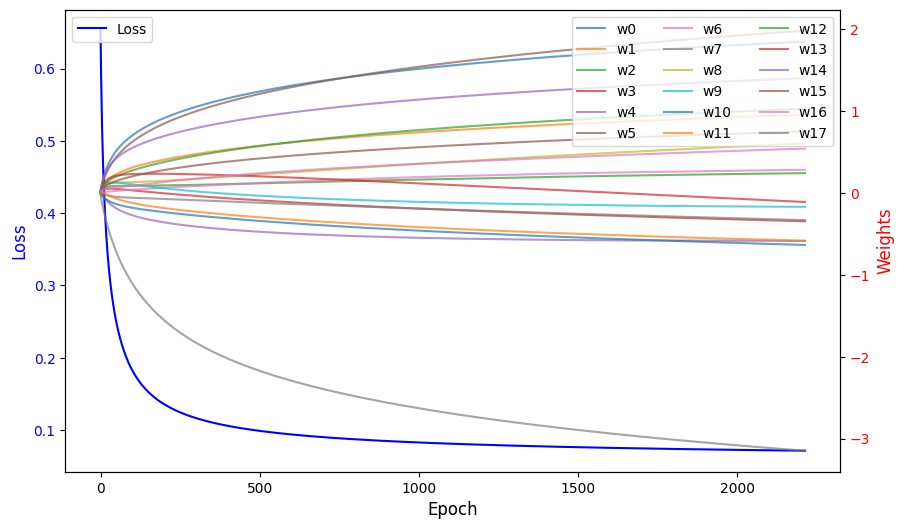

In [ ]:
plot_history(optimizer)

In [ ]:
yh_train = logist_model.predict(x_train)
yh_test = logist_model.predict(x_test)

print(f"Train accuracy: {accuracy(y_train, yh_train):.3}")
print(f"Test accuracy:  {accuracy(y_test, yh_test):.3}")

Train accuracy: 0.977
Test accuracy:  0.976


In [ ]:
# running gradient for various test/train splits (from 0.8 to 0.2)
test_split_range = np.arange(0.2, 0.8, 0.1)
logist_method_splits_df = pd.DataFrame()
iterations = 4

for test_split in test_split_range:
  for i in range(iterations):
    print(f"Test split: {test_split:.1} == iteration {i+1}/{iterations}")
    breast_test = breastdfnorm.sample(frac=test_split).reset_index(drop=True)
    breast_train = breastdfnorm.drop(breast_test.index).reset_index(drop=True)

    # Define target and features for both sets
    y_train = breast_train['Diagnosis']
    x_train = breast_train.drop(columns=['Diagnosis'])
    y_test = breast_test['Diagnosis']
    x_test = breast_test.drop(columns=['Diagnosis'])


    logist_model = LogisticRegression()
    optimizer = GradientDescent(learning_rate=.01, min_delta_loss=5e-6, max_iters=10000, record_history=False)
    logist_model.fit_gd_fullbatch(x_train, y_train, optimizer)
    yh_train = logist_model.predict(x_train)
    yh_test = logist_model.predict(x_test)
    logist_method_splits_df = store_logist_metrics(logist_method_splits_df, 'fullbatch', y_train, yh_train, y_test, yh_test, test_split, i)

# logist_method_splits_df

Test split: 0.2 == iteration 1/4
Test split: 0.2 == iteration 2/4
Test split: 0.2 == iteration 3/4
Test split: 0.2 == iteration 4/4
Test split: 0.3 == iteration 1/4
Test split: 0.3 == iteration 2/4
Test split: 0.3 == iteration 3/4
Test split: 0.3 == iteration 4/4
Test split: 0.4 == iteration 1/4
Test split: 0.4 == iteration 2/4
Test split: 0.4 == iteration 3/4
Test split: 0.4 == iteration 4/4
Test split: 0.5 == iteration 1/4
Test split: 0.5 == iteration 2/4
Test split: 0.5 == iteration 3/4
Test split: 0.5 == iteration 4/4
Test split: 0.6 == iteration 1/4
Test split: 0.6 == iteration 2/4
Test split: 0.6 == iteration 3/4
Test split: 0.6 == iteration 4/4
Test split: 0.7 == iteration 1/4
Test split: 0.7 == iteration 2/4
Test split: 0.7 == iteration 3/4
Test split: 0.7 == iteration 4/4
Test split: 0.8 == iteration 1/4
Test split: 0.8 == iteration 2/4
Test split: 0.8 == iteration 3/4
Test split: 0.8 == iteration 4/4


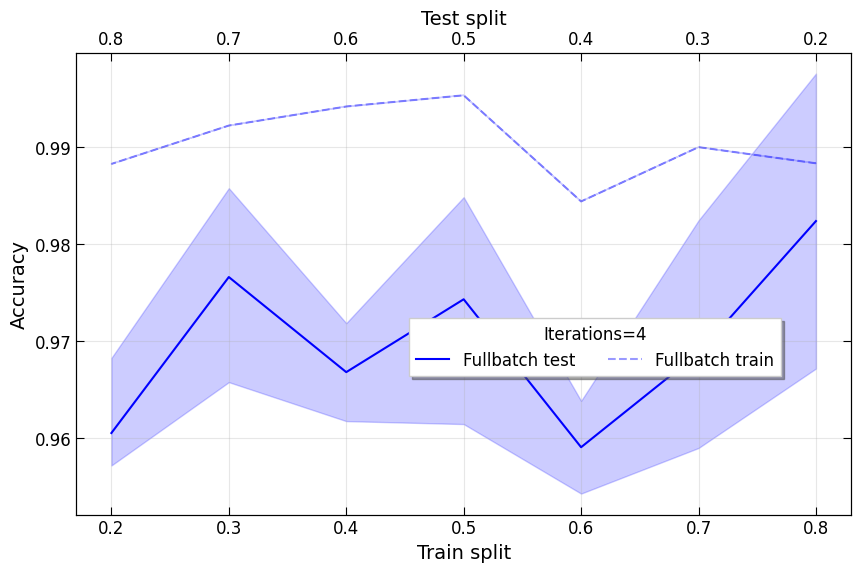

,test_split,median_test,mean_test,std_test,median_train,mean_train,std_train,upper_test,lower_test,upper_train,lower_train,train_split
0,0.2,0.982353,0.982353,0.015188,0.988304,0.988304,0.0,0.997541,0.967165,0.988304,0.988304,0.8
1,0.3,0.968750,0.970703,0.011719,0.989967,0.989967,0.0,0.982422,0.958984,0.989967,0.989967,0.7
2,0.4,0.959064,0.959064,0.004775,0.984375,0.984375,0.0,0.963839,0.954289,0.984375,0.984375,0.6
3,0.5,0.974299,0.973131,0.011682,0.995305,0.995305,0.0,0.984813,0.961449,0.995305,0.995305,0.5
4,0.6,0.966797,0.966797,0.005043,0.994152,0.994152,0.0,0.971840,0.961754,0.994152,0.994152,0.4


In [ ]:
# fullbatch
logist_full_stats = (
    logist_method_splits_df[logist_method_splits_df["method"] == "fullbatch"]
    .groupby("test_split")
    .agg(median_test=("test_accuracy", "median"), mean_test=("test_accuracy", "mean"), std_test=("test_accuracy", "std"),
         median_train=("train_accuracy", "median"), mean_train=("train_accuracy", "mean"), std_train=("train_accuracy", "std"))
    .reset_index()
)
logist_full_stats["upper_test"] = logist_full_stats["mean_test"] + logist_full_stats["std_test"]
logist_full_stats["lower_test"] = logist_full_stats["mean_test"] - logist_full_stats["std_test"]
logist_full_stats["upper_train"] = logist_full_stats["mean_train"] + logist_full_stats["std_train"]
logist_full_stats["lower_train"] = logist_full_stats["mean_train"] - logist_full_stats["std_train"]
logist_full_stats["train_split"] = 1-logist_full_stats["test_split"]




# plot accuracy vs test_split for fullbatch
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(logist_full_stats["train_split"], logist_full_stats["median_test"], label="Fullbatch test", c='b')
ax.fill_between(logist_full_stats["train_split"], logist_full_stats["lower_test"], logist_full_stats["upper_test"], color='b', alpha=.2)
ax.plot(logist_full_stats["train_split"], logist_full_stats["median_train"], label="Fullbatch train", c='b', ls='--', alpha=.4)
ax.fill_between(logist_full_stats["train_split"], logist_full_stats["lower_train"], logist_full_stats["upper_train"], color='b', alpha=.2, hatch='//')

# secondary x-axis for test splits
testax = ax.twiny()
testax.set_xlim(ax.get_xlim())  # align with train split axis
testax.set_xticks(logist_full_stats["train_split"])
testax.set_xticklabels(logist_full_stats["test_split"])
testax.set_xlabel("Test split", fontsize=14)
testax.tick_params(labelsize=12, direction='in', length=6)

ax.grid(alpha=.3)
ax.set_xlabel("Train split", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.tick_params(labelsize=12, direction='in', right=True, length=6)
ax.legend(loc=(0.43, 0.3), fontsize=12, ncols=2, shadow=True, fancybox=False, title=f'Iterations={iterations}', title_fontsize=12)
plt.show()

logist_full_stats.head()

# Plots for Report

make the train fraction plot here using all models